<a href="https://colab.research.google.com/github/shoreey/Predicting-Classes-of-Inflammatory-Bowel-Disease-using-Computer-Vision-Classification-/blob/main/Predicting_Classes_of_Inflammatory_Bowel_Disease_using_Computer_Vision_(_Classification_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification to predict classes from endoscopy and histology data

# Imporitng Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import io
import pandas as pd
import random
import scipy.io as sio
from scipy import ndimage
import scipy
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from scipy.io import loadmat
import torch
import torch.nn as nn
import math
from functools import partial
from torch.autograd import Variable
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import datetime
import copy
from PIL import Image

# Importing the Libraries

In [ ]:
# DataFrame
BASE_DIR = "E:/Data Science/Dissertation/Additional Work/Sukhjinder_bajwa_4126047/Data"
data_df = pd.read_excel("E:/Data Science/Dissertation/Additional Work/Sukhjinder_bajwa_4126047/PicassoOnly_AI_corretti_rev.xlsx")

# Define the threshold for exceeded values
threshold = 5  #

# Combine endoscopic and histological scores by summing threshold-exceeded values
data_df['Combined_Score'] = (
    (data_df['UCEIS>1'] > 0).astype(int) +
    (data_df['MES>1'] > 0).astype(int) +
    (data_df['Score'] > 0).astype(int) +
    (data_df['RHI>3'] > 0).astype(int) +
    (data_df['Nancy>0'] > 0).astype(int) +
    (data_df['PHRI'] > 0).astype(int)
)

# Apply the threshold
data_df['Threshold_Exceeded'] = (data_df['Combined_Score'] >= threshold).astype(int)

# Create a binary class based on the threshold
data_df['Class'] = (data_df['Threshold_Exceeded'] > 0).astype(int)

# Display the resulting DataFrame with the new columns
print(data_df[['UCEIS>1', 'MES>1', 'Score', 'RHI>3', 'Nancy>0', 'PHRI', 'Combined_Score', 'Threshold_Exceeded', 'Class']])


     UCEIS>1  MES>1  Score  RHI>3  Nancy>0  PHRI  Combined_Score  \
0          5    3.0     13    8.0      4.0   3.0               6   
1          0    0.0      0    2.0      2.0   3.0               3   
2          0    0.0      0    1.0      0.0   0.0               1   
3          1    0.0      0    1.0      0.0   0.0               2   
4          0    0.0      0    0.0      0.0   0.0               0   
..       ...    ...    ...    ...      ...   ...             ...   
555        1    0.0      1    1.0      0.0   0.0               3   
556        0    0.0      0    1.0      0.0   0.0               1   
557        0    0.0      0    1.0      0.0   0.0               1   
558        8    3.0     15   12.0      4.0   4.0               6   
559        0    0.0      0    0.0      0.0   0.0               0   

     Threshold_Exceeded  Class  
0                     1      1  
1                     0      0  
2                     0      0  
3                     0      0  
4                 

# Checking the Loading of the Frames

Frames shape: (320, 412, 3, 15)
Number of frames: 15


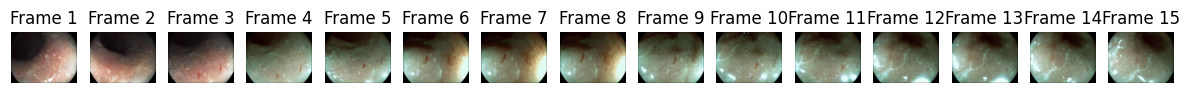

dict_keys(['__header__', '__version__', '__globals__', 'x'])


In [ ]:
# Function to load frames from mat files
def load_frames_from_mat(data_df):
    mat_file_path = os.path.join(BASE_DIR, data_df)

    # Load the variable 'x' from the mat file
    mat_data = loadmat(mat_file_path)
    frames = mat_data['x']

    return mat_data, frames

# Test loading frames from the first row of the dataset
mat_data, sample_frames = load_frames_from_mat(data_df['Filename'].iloc[0])

# Display information about the loaded frames
print(f"Frames shape: {sample_frames.shape}")
print(f"Number of frames: {sample_frames.shape[-1]}")

# Display all frames using matplotlib
num_frames = sample_frames.shape[-1]

plt.figure(figsize=(15, 5))
for i in range(num_frames):
    plt.subplot(1, num_frames, i + 1)
    plt.imshow(sample_frames[:, :, :, i])
    plt.axis('off')
    plt.title(f"Frame {i + 1}")

plt.show()

# Print keys of the loaded data
print(mat_data.keys())


# Data Visualization

Mucosal histogram counts:
Bin 0.00-0.45: 189
Bin 0.45-0.90: 0
Bin 0.90-1.35: 27
Bin 1.35-1.80: 0
Bin 1.80-2.25: 9
Bin 2.25-2.70: 0
Bin 2.70-3.15: 16
Bin 3.15-3.60: 0
Bin 3.60-4.05: 13
Bin 4.05-4.50: 0
Bin 4.50-4.95: 0
Bin 4.95-5.40: 11
Bin 5.40-5.85: 0
Bin 5.85-6.30: 21
Bin 6.30-6.75: 0
Bin 6.75-7.20: 16
Bin 7.20-7.65: 0
Bin 7.65-8.10: 5
Bin 8.10-8.55: 0
Bin 8.55-9.00: 9


Vascular histogram counts:
Bin 0.00-0.30: 148
Bin 0.30-0.60: 0
Bin 0.60-0.90: 0
Bin 0.90-1.20: 54
Bin 1.20-1.50: 0
Bin 1.50-1.80: 0
Bin 1.80-2.10: 29
Bin 2.10-2.40: 0
Bin 2.40-2.70: 0
Bin 2.70-3.00: 0
Bin 3.00-3.30: 34
Bin 3.30-3.60: 0
Bin 3.60-3.90: 0
Bin 3.90-4.20: 24
Bin 4.20-4.50: 0
Bin 4.50-4.80: 0
Bin 4.80-5.10: 14
Bin 5.10-5.40: 0
Bin 5.40-5.70: 0
Bin 5.70-6.00: 12


Score histogram counts:
Bin 0.00-0.75: 265
Bin 0.75-1.50: 84
Bin 1.50-2.25: 45
Bin 2.25-3.00: 0
Bin 3.00-3.75: 27
Bin 3.75-4.50: 22
Bin 4.50-5.25: 10
Bin 5.25-6.00: 0
Bin 6.00-6.75: 7
Bin 6.75-7.50: 16
Bin 7.50-8.25: 7
Bin 8.25-9.00: 0
Bin 9.00-9.

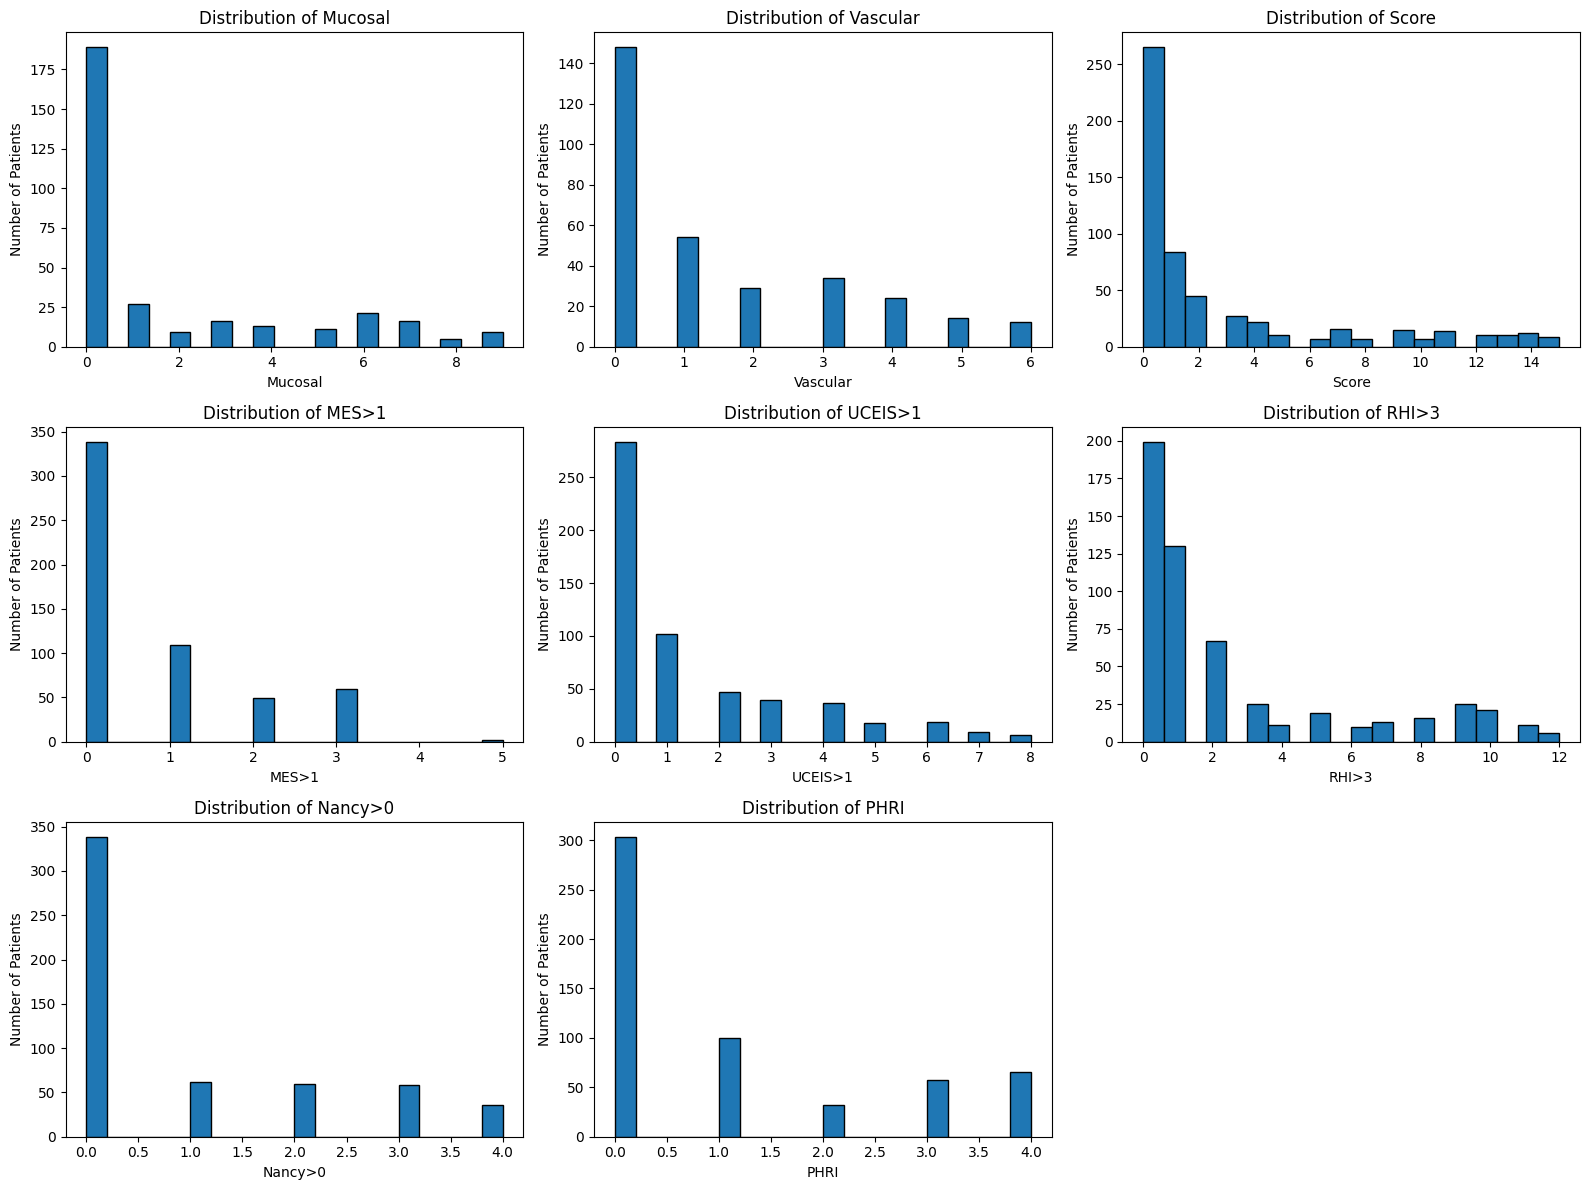

In [ ]:
# Extract relevant columns
columns_of_interest = ['Mucosal', 'Vascular', 'Score', 'MES>1', 'UCEIS>1', 'RHI>3', 'Nancy>0', 'PHRI']

# Plot histograms for each column
plt.figure(figsize=(16, 12))

for i, column in enumerate(columns_of_interest, 1):
    plt.subplot(3, 3, i)
    counts, edges, _ = plt.hist(data_df[column].dropna(), bins=20, edgecolor='black')  # You can adjust the number of bins as needed
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Number of Patients')

    # Print values of the counts
    print(f'{column} histogram counts:')
    for edge, count in zip(edges[:-1], counts):
        print(f'Bin {edge:.2f}-{edges[edges.searchsorted(edge)+1]:.2f}: {int(count)}')

    print('\n')

plt.tight_layout()
plt.show()


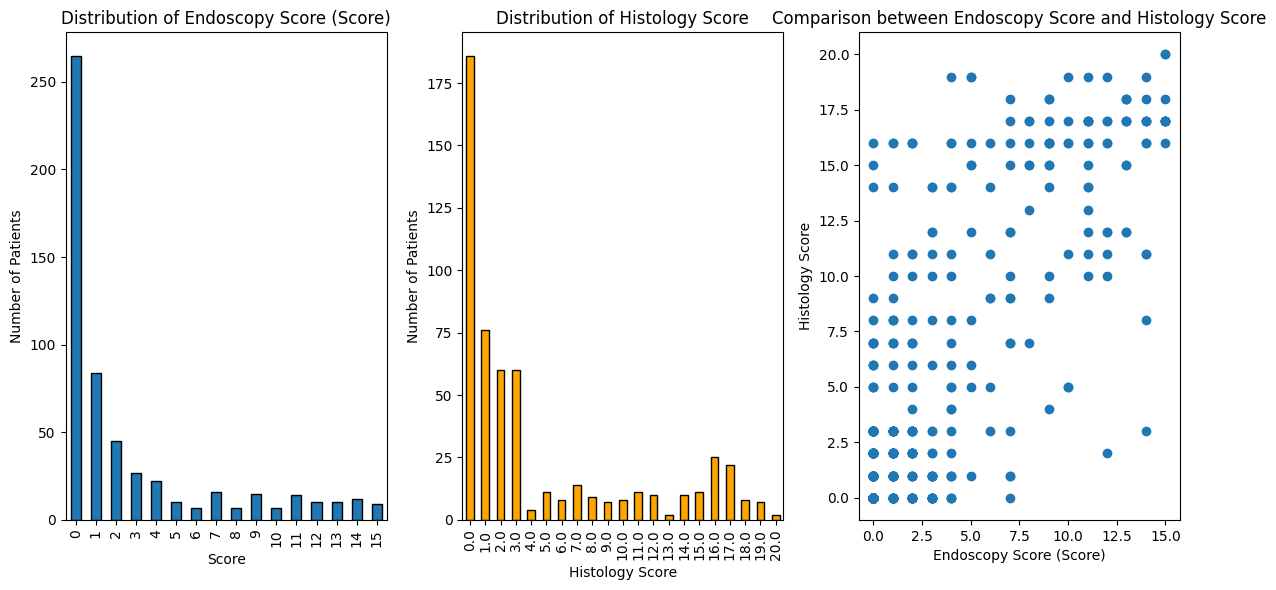

Distribution of Endoscopy Score (Score):
Score
0     265
1      84
2      45
3      27
4      22
5      10
6       7
7      16
8       7
9      15
10      7
11     14
12     10
13     10
14     12
15      9
Name: count, dtype: int64

Distribution of Histology Score (RHI, NANCY, PHRI):
Histology Score
0.0     186
1.0      76
2.0      60
3.0      60
4.0       4
5.0      11
6.0       8
7.0      14
8.0       9
9.0       7
10.0      8
11.0     11
12.0     10
13.0      2
14.0     10
15.0     11
16.0     25
17.0     22
18.0      8
19.0      7
20.0      2
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt

# Calculate the combined histology score
data_df['Histology Score'] = (
    data_df['RHI>3'] +
    data_df['Nancy>0'] +
    data_df['PHRI']
)

# Plotting the distribution of Endoscopy Score (Score)
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
data_df['Score'].value_counts().sort_index().plot(kind='bar', edgecolor='black')
plt.title('Distribution of Endoscopy Score (Score)')
plt.xlabel('Score')
plt.ylabel('Number of Patients')

# Plotting the distribution of Histology Score (RHI, NANCY, PHRI)
plt.subplot(1, 3, 2)
data_df['Histology Score'].value_counts().sort_index().plot(kind='bar', edgecolor='black', color='orange')
plt.title('Distribution of Histology Score')
plt.xlabel('Histology Score')
plt.ylabel('Number of Patients')

# Comparing Endoscopy Score and Histology Score
plt.subplot(1, 3, 3)
plt.scatter(data_df['Score'], data_df['Histology Score'])
plt.title('Comparison between Endoscopy Score and Histology Score')
plt.xlabel('Endoscopy Score (Score)')
plt.ylabel('Histology Score')

plt.tight_layout()
plt.show()

# Print the distribution of Endoscopy Score (Score)
print("Distribution of Endoscopy Score (Score):")
print(data_df['Score'].value_counts().sort_index())

# Print the distribution of Histology Score (RHI, NANCY, PHRI)
print("\nDistribution of Histology Score (RHI, NANCY, PHRI):")
print(data_df['Histology Score'].value_counts().sort_index())


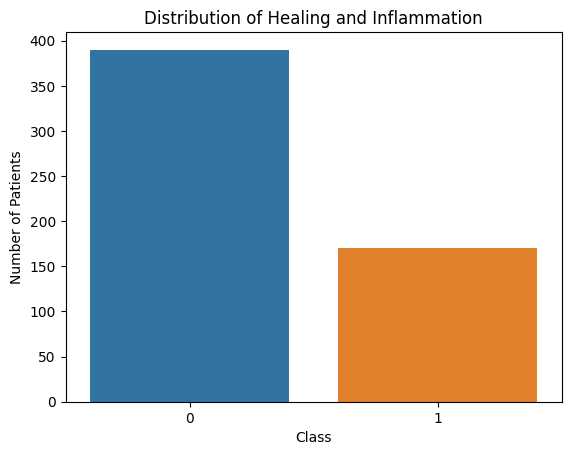


Count of Healing and Inflammation:
Class
0    390
1    170
Name: count, dtype: int64


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming the column indicating healing or inflammation is named 'Class'
# Adjust the column name accordingly if it's different
sns.countplot(x='Class', data=data_df)
plt.title('Distribution of Healing and Inflammation')
plt.xlabel('Class')
plt.ylabel('Number of Patients')
plt.show()

# Print the count of each class
class_counts = data_df['Class'].value_counts()
print("\nCount of Healing and Inflammation:")
print(class_counts)




Distribution of Combined Endoscopy Score Classes:
Count in 0-4: 443
Count in 4-8: 40
Count in 8-12: 46
Count in 12-15: 31


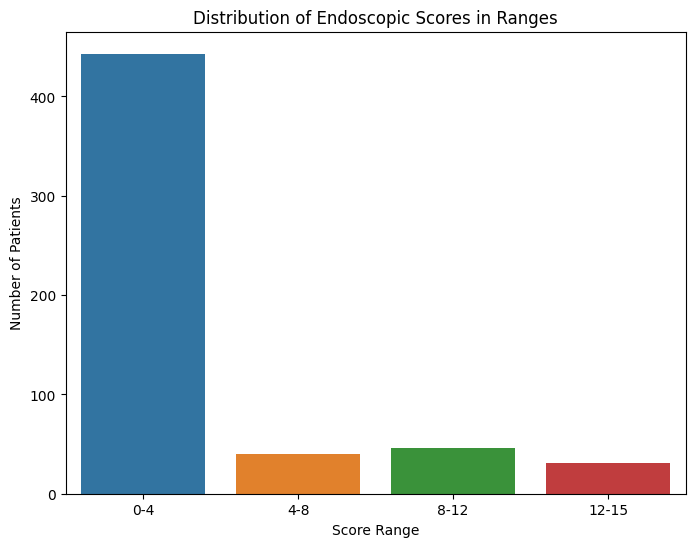

Distribution of Combined Histology Score Classes:
Histology_Class
0-4     386
4-8      42
8-12    123
Name: count, dtype: int64


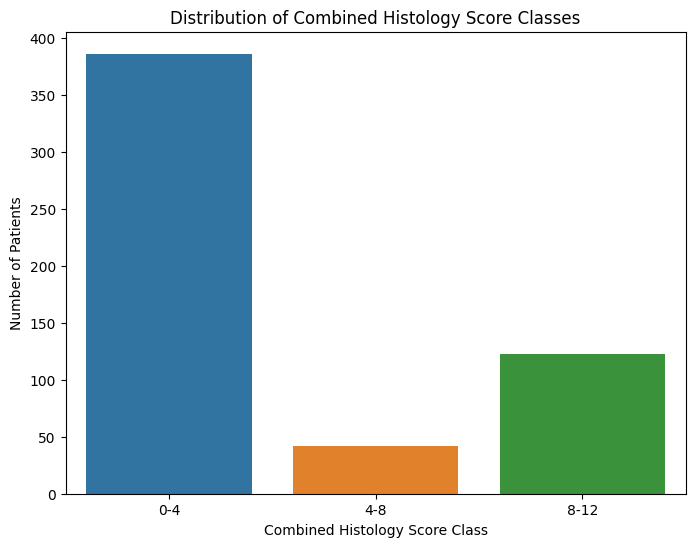

In [ ]:
import seaborn as sns

# Define custom bins for the 'Score' ranges
bins = [0, 4, 8, 12, 15]

# Create a new column 'Score_Range' to categorize scores into the specified bins
data_df['Score_Range'] = pd.cut(data_df['Score'], bins=bins, include_lowest=True, labels=['0-4', '4-8', '8-12', '12-15'])

# Plotting the distribution of 'Score' in specified ranges
plt.figure(figsize=(8, 6))
sns.countplot(x='Score_Range', data=data_df, order=['0-4', '4-8', '8-12', '12-15'])
plt.title('Distribution of Endoscopic Scores in Ranges')
plt.xlabel('Score Range')
plt.ylabel('Number of Patients')
print("Distribution of Combined Endoscopy Score Classes:")
# Print the count for each score range
score_range_counts = data_df['Score_Range'].value_counts().sort_index()
for score_range, count in zip(score_range_counts.index, score_range_counts):
    print(f"Count in {score_range}: {count}")

plt.show()


# Calculate the combined histology score
data_df['Histology Score'] = (
    data_df['RHI>3'] +
    data_df['Nancy>0'] +
    data_df['PHRI']
)

# Define custom bins for the 'Histology Score' ranges
hist_bins = [-1, 4, 8, data_df['Histology Score'].max()]

# Create a new column 'Histology_Class' to categorize scores into the specified bins
data_df['Histology_Class'] = pd.cut(data_df['Histology Score'], bins=hist_bins, include_lowest=True, labels=['0-4', '4-8', '8-12'])

# Print the distribution of the combined histology score classes
print("Distribution of Combined Histology Score Classes:")
print(data_df['Histology_Class'].value_counts().sort_index())

# Plotting the distribution of the combined histology score classes
plt.figure(figsize=(8, 6))
sns.countplot(x='Histology_Class', data=data_df, order=['0-4', '4-8', '8-12'])
plt.title('Distribution of Combined Histology Score Classes')
plt.xlabel('Combined Histology Score Class')
plt.ylabel('Number of Patients')
plt.show()





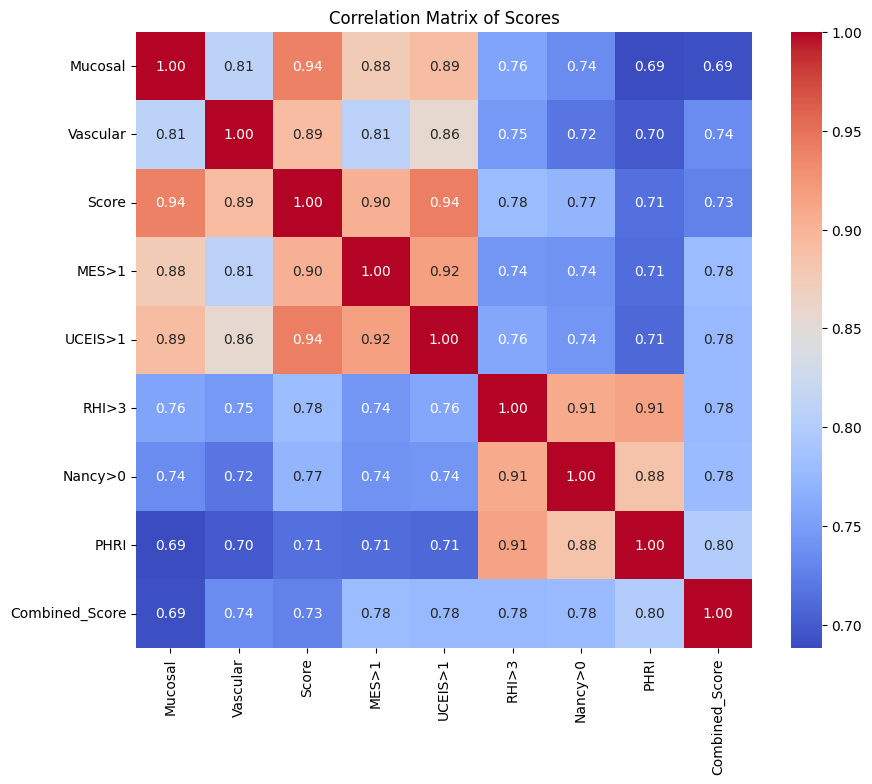


Correlation Matrix:
                 Mucosal  Vascular     Score     MES>1   UCEIS>1     RHI>3  \
Mucosal         1.000000  0.809348  0.939959  0.875137  0.891043  0.756544   
Vascular        0.809348  1.000000  0.891784  0.808173  0.855307  0.745920   
Score           0.939959  0.891784  1.000000  0.903711  0.940450  0.779535   
MES>1           0.875137  0.808173  0.903711  1.000000  0.916852  0.743798   
UCEIS>1         0.891043  0.855307  0.940450  0.916852  1.000000  0.758785   
RHI>3           0.756544  0.745920  0.779535  0.743798  0.758785  1.000000   
Nancy>0         0.735131  0.718437  0.771592  0.740888  0.743854  0.908217   
PHRI            0.688514  0.699305  0.714439  0.711831  0.708105  0.914332   
Combined_Score  0.691111  0.735089  0.728358  0.778963  0.777294  0.776743   

                 Nancy>0      PHRI  Combined_Score  
Mucosal         0.735131  0.688514        0.691111  
Vascular        0.718437  0.699305        0.735089  
Score           0.771592  0.714439     

In [ ]:
# Extract columns related to scores
score_columns = ['Mucosal', 'Vascular', 'Score', 'MES>1', 'UCEIS>1', 'RHI>3', 'Nancy>0', 'PHRI', 'Combined_Score']

# Create a correlation matrix
correlation_matrix = data_df[score_columns].corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix of Scores')
plt.show()

# Print the correlation matrix
print("\nCorrelation Matrix:")
print(correlation_matrix)


# Building the Dataset

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import scipy.io as sio

####################################################################################################################
#CREATE A DATASET CLASS
# The Dataset class is managing the information for the file at a specific index
# It will manage the loading of the frames from the mat file and the relevant information from the dataframe
####################################################################################################################

class IBD_Dataset(Dataset):
    def __init__(self,df:pd.DataFrame,imfolder:str,train:bool = True, transforms=None):
        self.df=df
        self.imfolder=imfolder
        self.train=train
        self.transforms=transforms
    def __getitem__(self,index):
        filename=self.df.iloc[index]['Filename'];
        #print(filename)
        im_path=os.path.join(self.imfolder,filename.strip())
        data = sio.loadmat(im_path)
        img = data['x']
        # Select frames with a mean intensity >20 to exclude frames with no information or too dark
        img_mean=img.mean(axis=0).mean(axis=0)
        img_mean=img_mean[0,:].squeeze()
        img=img[:,:,:,img_mean>20]

        sx=img.shape
        numframe=sx[3]
        posframe=np.zeros((numframe,))

        x=torch.zeros(numframe,3,224,224)
        img=img[:,0:400,:,:]
        img = torch.from_numpy(img)
        img=img.permute((3,0,1,2))
        for i in range(numframe):
            tmp=img[i,:,:,:].squeeze()
            #tmp=torch.tensor(tmp)
            tmp=tmp.type(torch.FloatTensor);
            tmp=tmp.permute(2,0,1)
            tmp = transforms.Resize((224,224))(tmp)
            tmp = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(tmp)
            #tmp=tmp.permute(1,2,0)
            x[i,:,:,:]=tmp
            if(self.train):
                framecol='VCE Frame ' + str(i+1)
                posframe[i]=self.df.iloc[index][framecol];
        if(self.train):
            # During training, for each video the Dataset returns
            #  - all frame x
            #  - the class y:  healing/inflames (0/1) for the video
            #  - the score w (for PICaSSO a number between 0 to 15)
            #  - the binary value posframe for each frames to containg (1) or not contain (0) any lesion
            y=self.df.iloc[index]['Class']
            w=self.df.iloc[index]['Score']
            return x, y, w, posframe
        else:
            # During testing, only the frames of the video are returned
            return x
    def __len__(self):
        return len(self.df)

# Extract all data belonging to the training set
train = data_df[data_df['Train_VCE_Endo'] == 1]

# Extract all data belonging to the validation set
valid = data_df[data_df['Train_VCE_Endo'] == 0]

# Reset index on both dataframes
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

# Targets for training and validation
train_targets = train.Class.values
valid_targets = valid.Class.values

# Transformation pipelines
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(45, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create instances of the IBD_Dataset class
train_dataset = IBD_Dataset(df=train, imfolder=BASE_DIR, train=True, transforms=train_transforms)
valid_dataset = IBD_Dataset(df=valid, imfolder=BASE_DIR, train=True, transforms=valid_transforms)


# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

# Create the dataloaders dictionary
dataloaders = {'train': train_loader, 'valid': valid_loader}




In [ ]:
def train_model(datasets, dataloaders, model, criterion1, criterion2, optimizer, scheduler, num_epochs, device):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100.0
    best_acc=0.0

    for epoch in range(num_epochs):
        preds=np.empty((0,1))
        targets=np.empty((0,1))
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corr = 0.0
            running_corrects_0=0.0
            running_corrects_1=0.0

            est_val=np.array([])
            prob_val=np.array([])
            true_val=np.array([])

            for inputs, labels, score, selframe in dataloaders[phase]:
                inputs = inputs.to(device).squeeze()
                labels=labels.type(torch.FloatTensor).to(device)
                selframe=selframe.type(torch.FloatTensor).to(device).squeeze()
                nframes=inputs.size()[0]
                #p1=torch.zeros(nframes,).to(device)
                #labels=scores.type(torch.FloatTensor).to(device)

                # Zero out the grads
                optimizer.zero_grad()
                # Forward
                # Track history in train mode
                with torch.set_grad_enabled(phase == 'train'):
                    model=model.to(device)
                    #print(inputs.size())
                    outputs, pframe = model(inputs)

                    #Multi instance aggregation
                    p1=1-torch.exp(-torch.sum(outputs,dim=0))
                    #print(p1.size())

                    #print(p1.size())
                    #print(labels.size())
                    loss1 = criterion1(p1, labels)
                    loss2 = criterion2(pframe,selframe.unsqueeze(1))

                    loss = loss1 + loss2

                    preds = p1>0.5
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    # Statistics
                    running_loss += loss.item()*inputs.size(0)
                    if labels==0:
                        running_corrects_0 += torch.sum(preds == labels)
                    else:
                        running_corrects_1 += torch.sum(preds == labels)
                    if phase == 'valid':
                        prob_val=np.concatenate((prob_val, p1.detach().to(torch.device("cpu"))), axis=0)
                        true_val=np.concatenate((true_val, labels.to(torch.device("cpu")).detach().to(torch.device("cpu")).numpy()),axis=0)

            if phase == 'train':
                scheduler.step()
            # Statistics
            epoch_loss = running_loss/len(datasets[phase])
            epoch_acc = (running_corrects_0+running_corrects_1)/len(datasets[phase])
            acc_0=running_corrects_0/(sum(datasets[phase].df['Class']==0))
            acc_1=running_corrects_1/(sum(datasets[phase].df['Class']==1))
            epoch_balacc = 0.5*(acc_0+acc_1)

            print('{} Loss: {:.4f} Acc: {:.4f} Balanced Acc: {:.4f} Class 0: {:.4f} Class 1: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, epoch_balacc, acc_0, acc_1))

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_bacc=epoch_balacc
                best_loss=epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'IBD_VCE_Picasso_ResNet50_frame_PicDiff_230619.pth')
                fpr, tpr, thresholds = metrics.roc_curve(true_val, prob_val)
                roc_auc = metrics.auc(fpr, tpr)
                cm = confusion_matrix(true_val, prob_val>0.5)
                ACC=(cm[0,0]+cm[1,1])/np.sum(cm)
                print('Saving model - AUC={:.4f} Acc={:.4f}'.format(roc_auc, ACC))
                display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='ResNet50 Transfer Learning')
                display.plot()
                plt.show()

            #if phase == 'valid':
            #    plt.plot(targets,preds,'o')
            #    plt.show()
            #if phase == 'valid' and epoch_loss < best_loss:
            #    best_loss = epoch_loss
            #    best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time()-since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))


    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def train_model(datasets, dataloaders, model, criterion1, criterion2, optimizer, scheduler, num_epochs, device):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100.0
    best_acc=0.0

    for epoch in range(num_epochs):
        preds=np.empty((0,1))
        targets=np.empty((0,1))
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corr = 0.0
            running_corrects_0=0.0
            running_corrects_1=0.0

            est_val=np.array([])
            prob_val=np.array([])
            true_val=np.array([])

            for inputs, labels, score, selframe in dataloaders[phase]:
                inputs = inputs.to(device).unsqueeze(0)
                labels=labels.type(torch.FloatTensor).to(device)
                selframe=selframe.type(torch.FloatTensor).to(device).squeeze()
                nframes=inputs.size()[0]
                #p1=torch.zeros(nframes,).to(device)
                #labels=scores.type(torch.FloatTensor).to(device)

                # Zero out the grads
                optimizer.zero_grad()
                # Forward
                # Track history in train mode
                with torch.set_grad_enabled(phase == 'train'):
                    model=model.to(device)
                    #print(inputs.size())
                    outputs, pframe = model(inputs)

                    #Multi instance aggregation
                    p1=1-torch.exp(-torch.sum(outputs,dim=0))
                    #print(p1.size())

                    #print(p1.size())
                    #print(labels.size())
                    loss1 = criterion1(p1, labels)
                    loss2 = criterion2(pframe,selframe.unsqueeze(1))

                    loss = loss1 + loss2

                    preds = p1>0.5
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    # Statistics
                    running_loss += loss.item()*inputs.size(0)
                    if labels==0:
                        running_corrects_0 += torch.sum(preds == labels)
                    else:
                        running_corrects_1 += torch.sum(preds == labels)
                    if phase == 'valid':
                        prob_val=np.concatenate((prob_val, p1.detach().to(torch.device("cpu"))), axis=0)
                        true_val=np.concatenate((true_val, labels.to(torch.device("cpu")).detach().to(torch.device("cpu")).numpy()),axis=0)

            if phase == 'train':
                scheduler.step()
            # Statistics
            epoch_loss = running_loss/len(datasets[phase])
            epoch_acc = (running_corrects_0+running_corrects_1)/len(datasets[phase])
            acc_0=running_corrects_0/(sum(datasets[phase].df['Class']==0))
            acc_1=running_corrects_1/(sum(datasets[phase].df['Class']==1))
            epoch_balacc = 0.5*(acc_0+acc_1)

            print('{} Loss: {:.4f} Acc: {:.4f} Balanced Acc: {:.4f} Class 0: {:.4f} Class 1: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, epoch_balacc, acc_0, acc_1))

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_bacc=epoch_balacc
                best_loss=epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'IBD_VCE_Picasso_ResNet50_frame_PicDiff_230619.pth')
                fpr, tpr, thresholds = metrics.roc_curve(true_val, prob_val)
                roc_auc = metrics.auc(fpr, tpr)
                cm = confusion_matrix(true_val, prob_val>0.5)
                ACC=(cm[0,0]+cm[1,1])/np.sum(cm)
                print('Saving model - AUC={:.4f} Acc={:.4f}'.format(roc_auc, ACC))
                display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='ResNet50 Transfer Learning')
                display.plot()
                plt.show()

            #if phase == 'valid':
            #    plt.plot(targets,preds,'o')
            #    plt.show()
            #if phase == 'valid' and epoch_loss < best_loss:
            #    best_loss = epoch_loss
            #    best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time()-since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))


    model.load_state_dict(best_model_wts)
    return model

# Building the Model

# Resnet50

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


class FrameAttentionResNet(nn.Module):
    def __init__(self):
        super(FrameAttentionResNet, self).__init__()

        self.numclass = 2

        # Use ResNet50 as the backbone with default weights
        self.resnet = models.resnet50(pretrained=True)

        # Freeze layers up to a certain point (adjust as needed)
        ct = 0
        for child in self.resnet.children():
            ct += 1
            if ct < 8:
                for param in child.parameters():
                    param.requires_grad = False

        # Modify the classification head
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, self.numclass)

        # Add gated attention inputs to the classification layer
        self.resnet.fc = nn.Linear(num_ftrs, self.numclass)
        self.head2 = nn.Linear(num_ftrs, 1)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.resnet.avgpool(x)
        xf = torch.flatten(x, 1)

        # Aggregation
        x = self.resnet.fc(xf)

        y = self.head2(xf)
        y = torch.sigmoid(y)

        sel = torch.cat((1 - y, y), dim=1)
        x = torch.mul(x, sel)

        return x, y

model = FrameAttentionResNet()

# Set the device for training
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Move model to the device
model.to(device)

# Lists to store metrics for plotting
train_losses = []
valid_losses = []
accuracies = []

# Number of training epochs
num_epochs = 10

# Loss function (CrossEntropyLoss for classification)
criterion = nn.CrossEntropyLoss()

# Optimizer (SGD as an example)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels, _, posframe in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        # Move inputs, labels, and posframe to the device
        inputs, labels, posframe = inputs.to(device), labels.to(device), posframe.to(device)

        optimizer.zero_grad()
        x, y = model(inputs)  # Assuming model returns two outputs, class predictions (x) and attention scores (y)

        # Convert labels to the correct data type (torch.long)
        labels = labels.type(torch.long)

        # Use posframe for something during training if needed

        loss = criterion(x, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = x.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)

    accuracy_train = 100 * correct_train / total_train
    accuracies.append(accuracy_train)

    print(f'Training Loss (Epoch {epoch + 1}/{num_epochs}): {average_loss:.4f}')
    print(f'Training Accuracy (Epoch {epoch + 1}/{num_epochs}): {accuracy_train:.2f}%')

    # Validation (optional)
    model.eval()
    total_valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels, _, _ in tqdm(valid_loader, desc=f'Validation (Epoch {epoch + 1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)

            # Convert labels to the correct data type (torch.long)
            labels = labels.type(torch.long)

            x, _ = model(inputs)  # Assuming model returns two outputs, class predictions (x) and attention scores (y)
            valid_loss = criterion(x, labels)
            total_valid_loss += valid_loss.item()

            _, predicted = x.max(1)
            total_valid += labels.size(0)
            correct_valid += predicted.eq(labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    average_valid_loss = total_valid_loss / len(valid_loader)
    valid_losses.append(average_valid_loss)

    accuracy_valid = 100 * correct_valid / total_valid
    print(f'Validation Loss (Epoch {epoch + 1}/{num_epochs}): {average_valid_loss:.4f}')
    print(f'Validation Accuracy (Epoch {epoch + 1}/{num_epochs}): {accuracy_valid:.2f}%')

# Confusion Matrix (at the end)
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print('Confusion Matrix:\n', cm)

# Classification Report (at the end)
report = classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1'])
print('Classification Report:\n', report)

# Plotting
plt.figure(figsize=(10, 5))

# Plotting Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



Epoch 1/10:   0%|          | 0/245 [00:00<?, ?it/s]


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 15, 3, 224, 224]

# Resnet18

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class FrameAttentionResNet18(nn.Module):
    def __init__(self):
        super(FrameAttentionResNet18, self).__init__()

        self.numclass = 2

        # Use ResNet18 as the backbone with default weights
        self.resnet18 = models.resnet18(pretrained=True)

        # Freeze layers up to a certain point (adjust as needed)
        ct = 0
        for child in self.resnet18.children():
            ct += 1
            if ct < 6:
                for param in child.parameters():
                    param.requires_grad = False

        # Modify the classification head
        num_ftrs = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(num_ftrs, self.numclass)

        # Add gated attention inputs to the classification layer
        self.resnet18.fc = nn.Linear(num_ftrs, self.numclass)
        self.head2 = nn.Linear(num_ftrs, 1)

    def forward(self, x):
        x = self.resnet18.conv1(x)
        x = self.resnet18.bn1(x)
        x = self.resnet18.relu(x)
        x = self.resnet18.maxpool(x)

        x = self.resnet18.layer1(x)
        x = self.resnet18.layer2(x)
        x = self.resnet18.layer3(x)
        x = self.resnet18.layer4(x)

        x = self.resnet18.avgpool(x)
        xf = torch.flatten(x, 1)

        # Aggregation
        x = self.resnet18.fc(xf)

        y = self.head2(xf)
        y = torch.sigmoid(y)

        sel = torch.cat((1 - y, y), dim=1)
        x = torch.mul(x, sel)

        return x, y

model = FrameAttentionResNet18()



# Set the device for training
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Move model to the device
model.to(device)

# Lists to store metrics for plotting
train_losses = []
valid_losses = []
accuracies = []

# Number of training epochs
num_epochs = 10

# Loss function (CrossEntropyLoss for classification)
criterion = nn.CrossEntropyLoss()

# Optimizer (SGD as an example)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels, _, posframe in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        # Move inputs, labels, and posframe to the device
        inputs, labels, posframe = inputs.to(device), labels.to(device), posframe.to(device)

        optimizer.zero_grad()
        x, y = model(inputs)  # Assuming model returns two outputs, class predictions (x) and attention scores (y)

        # Convert labels to the correct data type (torch.long)
        labels = labels.type(torch.long)

        # Use posframe for something during training if needed

        loss = criterion(x, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = x.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)

    accuracy_train = 100 * correct_train / total_train
    accuracies.append(accuracy_train)

    print(f'Training Loss (Epoch {epoch + 1}/{num_epochs}): {average_loss:.4f}')
    print(f'Training Accuracy (Epoch {epoch + 1}/{num_epochs}): {accuracy_train:.2f}%')

    # Validation (optional)
    model.eval()
    total_valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels, _, _ in tqdm(valid_loader, desc=f'Validation (Epoch {epoch + 1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)

            # Convert labels to the correct data type (torch.long)
            labels = labels.type(torch.long)

            x, _ = model(inputs)  # Assuming model returns two outputs, class predictions (x) and attention scores (y)
            valid_loss = criterion(x, labels)
            total_valid_loss += valid_loss.item()

            _, predicted = x.max(1)
            total_valid += labels.size(0)
            correct_valid += predicted.eq(labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    average_valid_loss = total_valid_loss / len(valid_loader)
    valid_losses.append(average_valid_loss)

    accuracy_valid = 100 * correct_valid / total_valid
    print(f'Validation Loss (Epoch {epoch + 1}/{num_epochs}): {average_valid_loss:.4f}')
    print(f'Validation Accuracy (Epoch {epoch + 1}/{num_epochs}): {accuracy_valid:.2f}%')

# Confusion Matrix (at the end)
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print('Confusion Matrix:\n', cm)

# Classification Report (at the end)
report = classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1'])
print('Classification Report:\n', report)

# Plotting
plt.figure(figsize=(10, 5))

# Plotting Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



C:\Users\shaur\anaconda3\envs\yolov8\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10:   0%|          | 0/245 [00:00<?, ?it/s]


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 14, 3, 224, 224]

# Wide Resnet

C:\Users\shaur\anaconda3\envs\yolov8\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\shaur\anaconda3\envs\yolov8\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10: 100%|██████████| 245/245 [00:33<00:00,  7.29it/s]


Training Loss (Epoch 1/10): 0.7020
Training Accuracy (Epoch 1/10): 52.24%


Validation (Epoch 1/10: 100%|██████████| 62/62 [00:08<00:00,  7.56it/s]


Validation Loss (Epoch 1/10): 0.6526
Validation Accuracy (Epoch 1/10): 62.90%


Epoch 2/10: 100%|██████████| 245/245 [00:29<00:00,  8.44it/s]


Training Loss (Epoch 2/10): 0.7056
Training Accuracy (Epoch 2/10): 49.80%


Validation (Epoch 2/10: 100%|██████████| 62/62 [00:05<00:00, 10.64it/s]


Validation Loss (Epoch 2/10): 0.7039
Validation Accuracy (Epoch 2/10): 59.68%


Epoch 3/10: 100%|██████████| 245/245 [00:27<00:00,  8.84it/s]


Training Loss (Epoch 3/10): 0.7091
Training Accuracy (Epoch 3/10): 51.84%


Validation (Epoch 3/10: 100%|██████████| 62/62 [00:06<00:00, 10.21it/s]


Validation Loss (Epoch 3/10): 0.6576
Validation Accuracy (Epoch 3/10): 62.90%


Epoch 4/10: 100%|██████████| 245/245 [00:32<00:00,  7.64it/s]


Training Loss (Epoch 4/10): 0.7030
Training Accuracy (Epoch 4/10): 54.69%


Validation (Epoch 4/10: 100%|██████████| 62/62 [00:05<00:00, 10.44it/s]


Validation Loss (Epoch 4/10): 0.7170
Validation Accuracy (Epoch 4/10): 48.39%


Epoch 5/10: 100%|██████████| 245/245 [00:25<00:00,  9.43it/s]


Training Loss (Epoch 5/10): 0.7053
Training Accuracy (Epoch 5/10): 52.24%


Validation (Epoch 5/10: 100%|██████████| 62/62 [00:05<00:00, 10.71it/s]


Validation Loss (Epoch 5/10): 0.7088
Validation Accuracy (Epoch 5/10): 56.45%


Epoch 6/10: 100%|██████████| 245/245 [00:26<00:00,  9.32it/s]


Training Loss (Epoch 6/10): 0.7121
Training Accuracy (Epoch 6/10): 48.57%


Validation (Epoch 6/10: 100%|██████████| 62/62 [00:05<00:00, 10.48it/s]


Validation Loss (Epoch 6/10): 0.6658
Validation Accuracy (Epoch 6/10): 58.06%


Epoch 7/10: 100%|██████████| 245/245 [00:30<00:00,  8.12it/s]


Training Loss (Epoch 7/10): 0.7137
Training Accuracy (Epoch 7/10): 47.35%


Validation (Epoch 7/10: 100%|██████████| 62/62 [00:05<00:00, 10.60it/s]


Validation Loss (Epoch 7/10): 0.6706
Validation Accuracy (Epoch 7/10): 56.45%


Epoch 8/10: 100%|██████████| 245/245 [00:26<00:00,  9.19it/s]


Training Loss (Epoch 8/10): 0.7128
Training Accuracy (Epoch 8/10): 48.57%


Validation (Epoch 8/10: 100%|██████████| 62/62 [00:05<00:00, 10.87it/s]


Validation Loss (Epoch 8/10): 0.6723
Validation Accuracy (Epoch 8/10): 64.52%


Epoch 9/10: 100%|██████████| 245/245 [00:26<00:00,  9.33it/s]


Training Loss (Epoch 9/10): 0.7096
Training Accuracy (Epoch 9/10): 51.43%


Validation (Epoch 9/10: 100%|██████████| 62/62 [00:05<00:00, 10.82it/s]


Validation Loss (Epoch 9/10): 0.6725
Validation Accuracy (Epoch 9/10): 56.45%


Epoch 10/10: 100%|██████████| 245/245 [00:26<00:00,  9.25it/s]


Training Loss (Epoch 10/10): 0.7082
Training Accuracy (Epoch 10/10): 50.61%


Validation (Epoch 10/10: 100%|██████████| 62/62 [00:05<00:00, 11.06it/s]


Validation Loss (Epoch 10/10): 0.7094
Validation Accuracy (Epoch 10/10): 48.39%


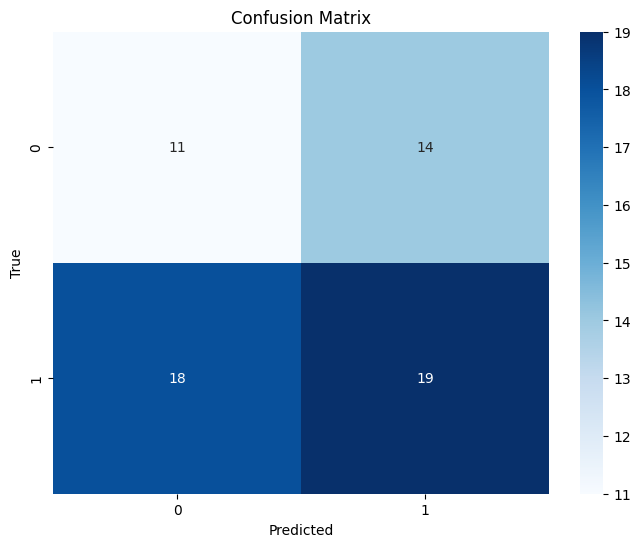

Confusion Matrix:
 [[11 14]
 [18 19]]
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.38      0.44      0.41        25
     Class 1       0.58      0.51      0.54        37

    accuracy                           0.48        62
   macro avg       0.48      0.48      0.48        62
weighted avg       0.50      0.48      0.49        62



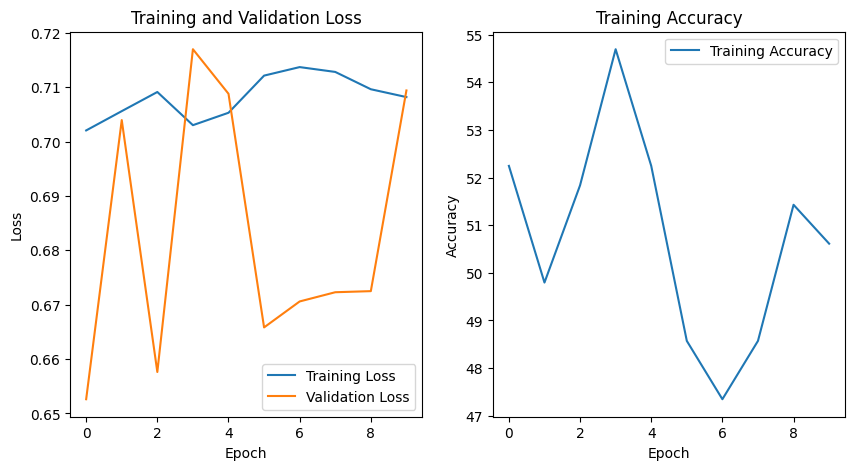

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class FrameAttentionWideResNet(nn.Module):
    def __init__(self):
        super(FrameAttentionWideResNet, self).__init__()

        self.numclass = 2

        # Use Wide ResNet-50-2 as the backbone with default weights
        self.wideresnet = models.wide_resnet50_2(pretrained=True)

        # Freeze layers up to a certain point (adjust as needed)
        ct = 0
        for child in self.wideresnet.children():
            ct += 1
            if ct < 6:
                for param in child.parameters():
                    param.requires_grad = False

        # Modify the classification head
        num_ftrs = self.wideresnet.fc.in_features
        self.wideresnet.fc = nn.Linear(num_ftrs, self.numclass)

        # Add gated attention inputs to the classification layer
        self.wideresnet.fc = nn.Linear(num_ftrs, self.numclass)
        self.head2 = nn.Linear(num_ftrs, 1)

    def forward(self, x):
        x = self.wideresnet.conv1(x)
        x = self.wideresnet.bn1(x)
        x = self.wideresnet.relu(x)
        x = self.wideresnet.maxpool(x)

        x = self.wideresnet.layer1(x)
        x = self.wideresnet.layer2(x)
        x = self.wideresnet.layer3(x)
        x = self.wideresnet.layer4(x)

        x = self.wideresnet.avgpool(x)
        xf = torch.flatten(x, 1)

        # Aggregation
        x = self.wideresnet.fc(xf)

        y = self.head2(xf)
        y = torch.sigmoid(y)

        sel = torch.cat((1 - y, y), dim=1)
        x = torch.mul(x, sel)

        return x, y

model_wideresnet = FrameAttentionWideResNet()
# Set the device for training
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Move model to the device
model.to(device)

# Lists to store metrics for plotting
train_losses = []
valid_losses = []
accuracies = []

# Number of training epochs
num_epochs = 10

# Loss function (CrossEntropyLoss for classification)
criterion = nn.CrossEntropyLoss()

# Optimizer (SGD as an example)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels, _, posframe in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        # Move inputs, labels, and posframe to the device
        inputs, labels, posframe = inputs.to(device), labels.to(device), posframe.to(device)

        optimizer.zero_grad()
        x, y = model(inputs)  # Assuming model returns two outputs, class predictions (x) and attention scores (y)

        # Convert labels to the correct data type (torch.long)
        labels = labels.type(torch.long)

        # Use posframe for something during training if needed

        loss = criterion(x, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = x.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)

    accuracy_train = 100 * correct_train / total_train
    accuracies.append(accuracy_train)

    print(f'Training Loss (Epoch {epoch + 1}/{num_epochs}): {average_loss:.4f}')
    print(f'Training Accuracy (Epoch {epoch + 1}/{num_epochs}): {accuracy_train:.2f}%')

    # Validation (optional)
    model.eval()
    total_valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels, _, _ in tqdm(valid_loader, desc=f'Validation (Epoch {epoch + 1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)

            # Convert labels to the correct data type (torch.long)
            labels = labels.type(torch.long)

            x, _ = model(inputs)  # Assuming model returns two outputs, class predictions (x) and attention scores (y)
            valid_loss = criterion(x, labels)
            total_valid_loss += valid_loss.item()

            _, predicted = x.max(1)
            total_valid += labels.size(0)
            correct_valid += predicted.eq(labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    average_valid_loss = total_valid_loss / len(valid_loader)
    valid_losses.append(average_valid_loss)

    accuracy_valid = 100 * correct_valid / total_valid
    print(f'Validation Loss (Epoch {epoch + 1}/{num_epochs}): {average_valid_loss:.4f}')
    print(f'Validation Accuracy (Epoch {epoch + 1}/{num_epochs}): {accuracy_valid:.2f}%')

# Confusion Matrix (at the end)
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print('Confusion Matrix:\n', cm)

# Classification Report (at the end)
report = classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1'])
print('Classification Report:\n', report)

# Plotting
plt.figure(figsize=(10, 5))

# Plotting Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()





# Resnetxt

C:\Users\shaur\anaconda3\envs\yolov8\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\shaur\anaconda3\envs\yolov8\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10: 100%|██████████| 245/245 [00:30<00:00,  8.01it/s]


Training Loss (Epoch 1/10): 0.7138
Training Accuracy (Epoch 1/10): 45.31


Validation (Epoch 1/10: 100%|██████████| 62/62 [00:06<00:00,  9.96it/s]


Validation Loss (Epoch 1/10): 0.6917
Validation Accuracy (Epoch 1/10): 54.84


Epoch 2/10: 100%|██████████| 245/245 [00:32<00:00,  7.57it/s]


Training Loss (Epoch 2/10): 0.6923
Training Accuracy (Epoch 2/10): 55.10


Validation (Epoch 2/10: 100%|██████████| 62/62 [00:06<00:00,  9.44it/s]


Validation Loss (Epoch 2/10): 0.8466
Validation Accuracy (Epoch 2/10): 40.32


Epoch 3/10: 100%|██████████| 245/245 [00:30<00:00,  8.03it/s]


Training Loss (Epoch 3/10): 0.7065
Training Accuracy (Epoch 3/10): 50.20


Validation (Epoch 3/10: 100%|██████████| 62/62 [00:06<00:00,  9.44it/s]


Validation Loss (Epoch 3/10): 0.6917
Validation Accuracy (Epoch 3/10): 50.00


Epoch 4/10: 100%|██████████| 245/245 [00:30<00:00,  8.12it/s]


Training Loss (Epoch 4/10): 0.7132
Training Accuracy (Epoch 4/10): 46.12


Validation (Epoch 4/10: 100%|██████████| 62/62 [00:06<00:00,  9.91it/s]


Validation Loss (Epoch 4/10): 0.6825
Validation Accuracy (Epoch 4/10): 59.68


Epoch 5/10: 100%|██████████| 245/245 [00:30<00:00,  7.96it/s]


Training Loss (Epoch 5/10): 0.7083
Training Accuracy (Epoch 5/10): 51.84


Validation (Epoch 5/10: 100%|██████████| 62/62 [00:06<00:00,  9.53it/s]


Validation Loss (Epoch 5/10): 0.7011
Validation Accuracy (Epoch 5/10): 53.23


Epoch 6/10: 100%|██████████| 245/245 [00:30<00:00,  8.10it/s]


Training Loss (Epoch 6/10): 0.6952
Training Accuracy (Epoch 6/10): 49.39


Validation (Epoch 6/10: 100%|██████████| 62/62 [00:06<00:00,  9.58it/s]


Validation Loss (Epoch 6/10): 0.6883
Validation Accuracy (Epoch 6/10): 48.39


Epoch 7/10: 100%|██████████| 245/245 [00:30<00:00,  7.93it/s]


Training Loss (Epoch 7/10): 0.6948
Training Accuracy (Epoch 7/10): 50.61


Validation (Epoch 7/10: 100%|██████████| 62/62 [00:06<00:00, 10.16it/s]


Validation Loss (Epoch 7/10): 0.6752
Validation Accuracy (Epoch 7/10): 61.29


Epoch 8/10: 100%|██████████| 245/245 [00:30<00:00,  8.12it/s]


Training Loss (Epoch 8/10): 0.6945
Training Accuracy (Epoch 8/10): 52.24


Validation (Epoch 8/10: 100%|██████████| 62/62 [00:06<00:00,  9.64it/s]


Validation Loss (Epoch 8/10): 0.6965
Validation Accuracy (Epoch 8/10): 56.45


Epoch 9/10: 100%|██████████| 245/245 [00:31<00:00,  7.87it/s]


Training Loss (Epoch 9/10): 0.6943
Training Accuracy (Epoch 9/10): 52.24


Validation (Epoch 9/10: 100%|██████████| 62/62 [00:06<00:00,  9.59it/s]


Validation Loss (Epoch 9/10): 0.6843
Validation Accuracy (Epoch 9/10): 56.45


Epoch 10/10: 100%|██████████| 245/245 [00:40<00:00,  6.07it/s]


Training Loss (Epoch 10/10): 0.6936
Training Accuracy (Epoch 10/10): 48.57


Validation (Epoch 10/10: 100%|██████████| 62/62 [00:08<00:00,  7.68it/s]


Validation Loss (Epoch 10/10): 0.6858
Validation Accuracy (Epoch 10/10): 61.29


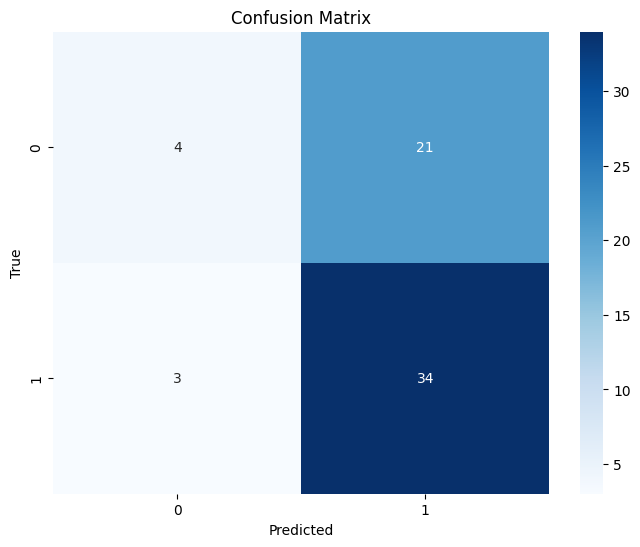

Confusion Matrix:
 [[ 4 21]
 [ 3 34]]
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.57      0.16      0.25        25
     Class 1       0.62      0.92      0.74        37

    accuracy                           0.61        62
   macro avg       0.59      0.54      0.49        62
weighted avg       0.60      0.61      0.54        62



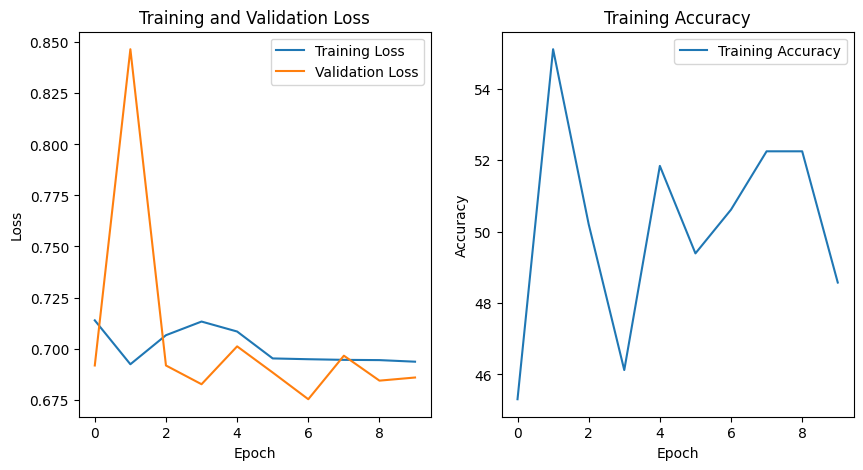

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torch.optim.lr_scheduler import StepLR

class FrameAttentionResNeXt(nn.Module):
    def __init__(self):
        super(FrameAttentionResNeXt, self).__init__()

        self.numclass = 2

        # Use ResNeXt-50-32x4d as the backbone with default weights
        self.resnext = models.resnext50_32x4d(pretrained=True)

        # Freeze layers up to a certain point (adjust as needed)
        ct = 0
        for child in self.resnext.children():
            ct += 1
            if ct < 6:
                for param in child.parameters():
                    param.requires_grad = False

        # Modify the classification head
        num_ftrs = self.resnext.fc.in_features
        self.resnext.fc = nn.Linear(num_ftrs, self.numclass)

        # Add gated attention inputs to the classification layer
        self.resnext.fc = nn.Linear(num_ftrs, self.numclass)
        self.head2 = nn.Linear(num_ftrs, 1)

    def forward(self, x):
        x = self.resnext.conv1(x)
        x = self.resnext.bn1(x)
        x = self.resnext.relu(x)
        x = self.resnext.maxpool(x)

        x = self.resnext.layer1(x)
        x = self.resnext.layer2(x)
        x = self.resnext.layer3(x)
        x = self.resnext.layer4(x)

        x = self.resnext.avgpool(x)
        xf = torch.flatten(x, 1)

        # Aggregation
        x = self.resnext.fc(xf)

        y = self.head2(xf)
        y = torch.sigmoid(y)

        sel = torch.cat((1 - y, y), dim=1)
        x = torch.mul(x, sel)

        return x, y

model_resnext = FrameAttentionResNeXt()


# Set the device for training
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Instantiate the model
model = FrameAttentionResNeXt().to(device)

# Lists to store metrics for plotting
train_losses = []
valid_losses = []
accuracies = []

# Number of training epochs
num_epochs = 10

# Loss function (CrossEntropyLoss for classification)
criterion = nn.CrossEntropyLoss()

# Optimizer (SGD as an example)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels, _, posframe in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        # Move inputs, labels, and posframe to the device
        inputs, labels, posframe = inputs.to(device), labels.to(device), posframe.to(device)

        optimizer.zero_grad()
        x, y = model(inputs)  # Assuming model returns two outputs, class predictions (x) and attention scores (y)

        # Convert labels to the correct data type (torch.long)
        labels = labels.type(torch.long)

        # Use posframe for something during training if needed

        loss = criterion(x, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = x.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)

    accuracy_train = 100 * correct_train / total_train
    accuracies.append(accuracy_train)

    print(f'Training Loss (Epoch {epoch + 1}/{num_epochs}): {average_loss:.4f}')
    print(f'Training Accuracy (Epoch {epoch + 1}/{num_epochs}): {accuracy_train:.2f}')

    # Validation (optional)
    model.eval()
    total_valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels, _, _ in tqdm(valid_loader, desc=f'Validation (Epoch {epoch + 1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)

            # Convert labels to the correct data type (torch.long)
            labels = labels.type(torch.long)

            x, _ = model(inputs)  # Assuming model returns two outputs, class predictions (x) and attention scores (y)
            valid_loss = criterion(x, labels)
            total_valid_loss += valid_loss.item()

            _, predicted = x.max(1)
            total_valid += labels.size(0)
            correct_valid += predicted.eq(labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    average_valid_loss = total_valid_loss / len(valid_loader)
    valid_losses.append(average_valid_loss)

    accuracy_valid = 100 * correct_valid / total_valid
    print(f'Validation Loss (Epoch {epoch + 1}/{num_epochs}): {average_valid_loss:.4f}')
    print(f'Validation Accuracy (Epoch {epoch + 1}/{num_epochs}): {accuracy_valid:.2f}')

    # Update the learning rate
    scheduler.step()

# Confusion Matrix (at the end)
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print('Confusion Matrix:\n', cm)
# Classification Report (at the end)
report = classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1'])
print('Classification Report:\n', report)
# Plotting
plt.figure(figsize=(10, 5))

# Plotting Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



# Comparison among the resnet Family

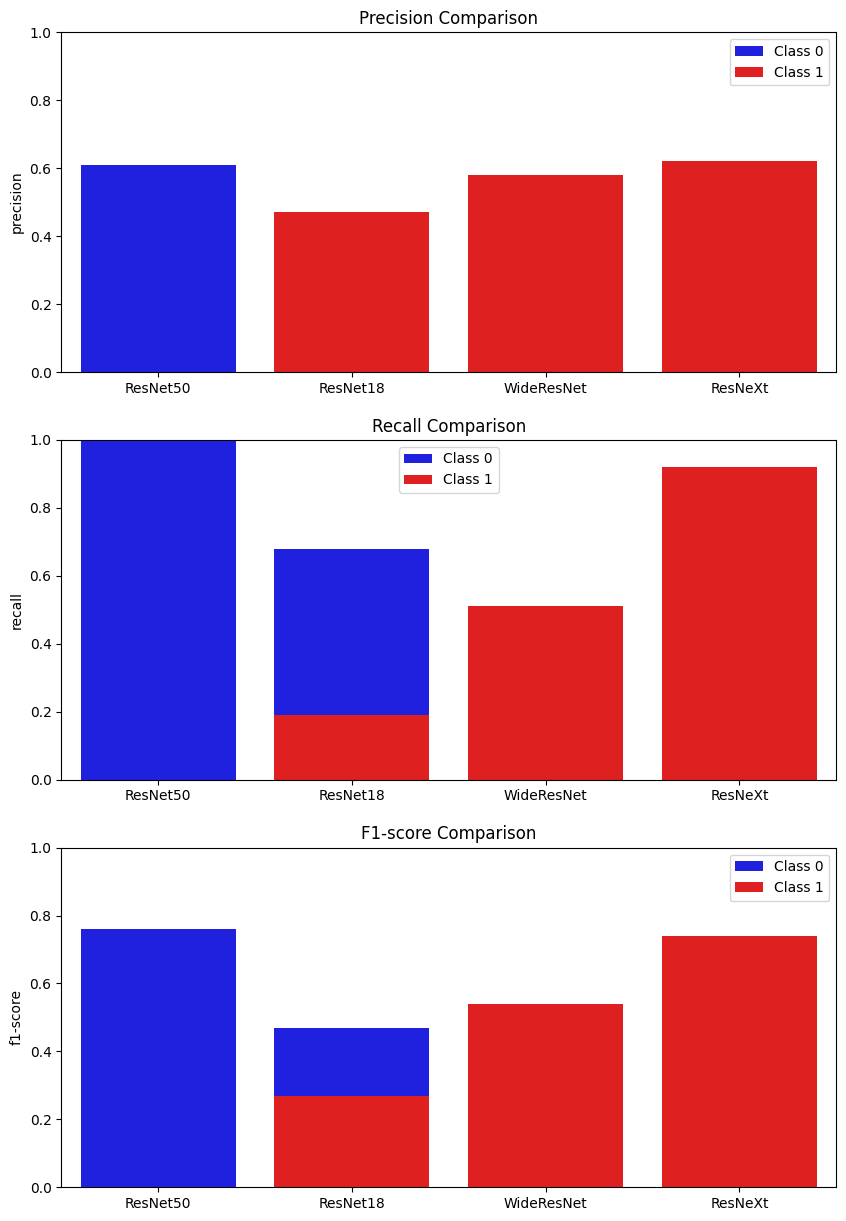

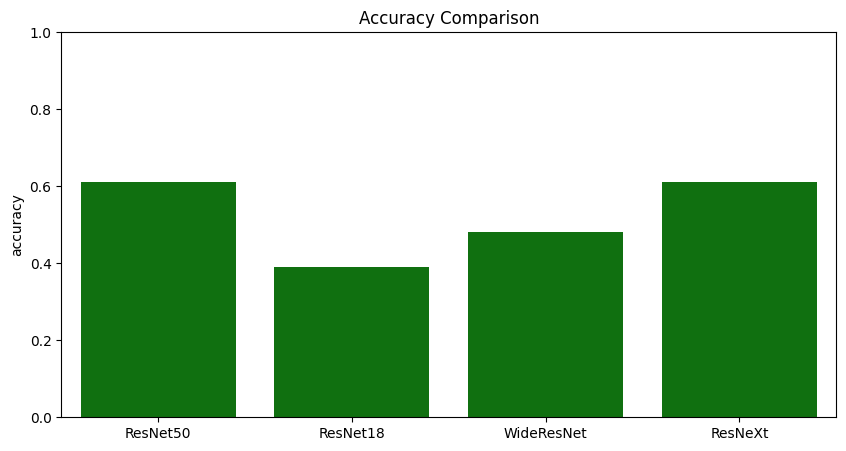

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

# Define the classification reports
reports = {
    'ResNet50': {
        'precision': [0.61, 0.00],
        'recall': [1.00, 0.00],
        'f1-score': [0.76, 0.00],
        'support': [38, 24],
        'accuracy': 0.61
    },
    'ResNet18': {
        'precision': [0.36, 0.47],
        'recall': [0.68, 0.19],
        'f1-score': [0.47, 0.27],
        'support': [25, 37],
        'accuracy': 0.39
    },
    'WideResNet': {
        'precision': [0.38, 0.58],
        'recall': [0.44, 0.51],
        'f1-score': [0.41, 0.54],
        'support': [25, 37],
        'accuracy': 0.48
    },
    'ResNeXt': {
        'precision': [0.57, 0.62],
        'recall': [0.16, 0.92],
        'f1-score': [0.25, 0.74],
        'support': [25, 37],
        'accuracy': 0.61
    }
}

# Convert the classification reports to a DataFrame
import pandas as pd
df_reports = pd.DataFrame(reports).T

# Plot precision, recall, and f1-score
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))
metrics = ['precision', 'recall', 'f1-score']

for i, metric in enumerate(metrics):
    sns.barplot(x=df_reports.index, y=df_reports[metric].apply(lambda x: x[0]), label='Class 0', ax=axes[i], color='b')
    sns.barplot(x=df_reports.index, y=df_reports[metric].apply(lambda x: x[1]), label='Class 1', ax=axes[i], color='r')

    axes[i].set_title(f'{metric.capitalize()} Comparison')
    axes[i].set_ylim(0, 1)
    axes[i].legend()

# Plot accuracy
plt.figure(figsize=(10, 5))
sns.barplot(x=df_reports.index, y=df_reports['accuracy'], color='g')
plt.title('Accuracy Comparison')
plt.ylim(0, 1)
plt.show()



# Predicting Discrepancy between endoscopic and Histology Scores in assessing inflammation

In [ ]:
data_df["Class"]=data_df["Pic_diff"]>0
data_df.head()
#print (len(data_df))


,Num,Video,Filename,Filename_WL_UCEIS,Mucosal,Vascular,Score,MES>1,UCEIS>1,RHI>3,...,VCE Frame 7,VCE Frame 8,VCE Frame 9,VCE Frame 10,VCE Frame 11,VCE Frame 12,VCE Frame 13,VCE Frame 14,VCE Frame 15,Class
0,1,01-01 rectum,muc_229_pat0101_section1.mat,muc_001_pat0101_section1.mat,7.0,3.0,13,3.0,5,8.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,False
1,2,01-01 sigmoid,muc_230_pat0101_section2.mat,none,0.0,0.0,0,0.0,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
2,3,01-02 rectum,muc_001_pat0102_section1.mat,muc_002_pat0102_section1.mat,0.0,0.0,0,0.0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
3,4,01-02 sigmoid,muc_002_pat0102_section2.mat,muc_003_pat0102_section2.mat,0.0,0.0,0,0.0,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
4,5,01-03 rectum,muc_003_pat0103_section1.mat,muc_004_pat0103_section1.mat,0.0,0.0,0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import scipy.io as sio

####################################################################################################################
#CREATE A DATASET CLASS
# The Dataset class is managing the information for the file at a specific index
# It will manage the loading of the frames from the mat file and the relevant information from the dataframe
####################################################################################################################


class IBD_Dataset(Dataset):
    def __init__(self,df:pd.DataFrame,imfolder:str,train:bool = True, transforms=None):
        self.df=df
        self.imfolder=imfolder
        self.train=train
        self.transforms=transforms
    def __getitem__(self,index):
        filename=self.df.iloc[index]['Filename'];
        im_path=os.path.join(self.imfolder,filename.strip())
        data = sio.loadmat(im_path)
        img = data['x']
        # Select frames with a mean intensity >20 to exclude frames with no information or too dark
        img_mean=img.mean(axis=0).mean(axis=0)
        img_mean=img_mean[0,:].squeeze()
        img=img[:,:,:,img_mean>20]

        sx=img.shape
        numframe=sx[3]
        if(self.train):
            # for each video 15 frames are available
            # select a single random frame from the video
            selframe=np.random.randint(low=0, high=numframe)
            # Return if the frames contain only normal mucosa (0)
            # or if it contains any lesion (1)
            framecol='VCE Frame ' + str(selframe+1)
            posframe=self.df.iloc[index][framecol];
            # Load the selected frame from the video
            # and applies the image resizing, cropping, normalization and augmentation
            x=img[:,0:400,:,selframe].squeeze()
            x=Image.fromarray(x)
            if(self.transforms):
                x=self.transforms(x)
            x=x.type(torch.FloatTensor);
        else:
            # when testing, all frames from a video are loaded
            x=torch.zeros(numframe,224,224,3)
            img=img[:,0:400,:,:]
            img = torch.from_numpy(img)
            # Assuming your image is loaded as img
            img = torch.unsqueeze(img, 0)
            img=img.permute((3,0,1,2))
            for i in range(numframe):
                tmp=img[i,:,:,:].squeeze()
                tmp=torch.tensor(tmp)
                tmp=tmp.type(torch.FloatTensor);
                tmp=tmp.permute(2,0,1)
                tmp = transforms.Resize((224,224))(tmp)
                tmp = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(tmp)
                tmp=tmp.permute(1,2,0)
                x[i,:,:,:]=tmp

        if(self.train):
            # During training, for each video the Dataset returns
            #  - a frame x
            #  - the class y:  healing/inflames (0/1) for the video
            #  - the score w (for PICaSSO a number between 0 to 15)
            #  - the binary value posframe for the frame to containg (1) or not contain (0) any lesion
            y=self.df.iloc[index]['Class']
            w=self.df.iloc[index]['Score']
            return x,y, w, posframe
        else:
            # During testing, only the frames of the video are returned
            return x
    def __len__(self):
        return len(self.df)

# Extract all data belonging to the training set
train = data_df[data_df['Train_VCE_Endo'] == 1]

# Extract all data belonging to the validation set
valid = data_df[data_df['Train_VCE_Endo'] == 0]

# Reset index on both dataframes
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

# Targets for training and validation
train_targets = train.Class.values
valid_targets = valid.Class.values

# Transformation pipelines
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(45, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create instances of the IBD_Dataset class
train_dataset = IBD_Dataset(df=train, imfolder=BASE_DIR, train=True, transforms=train_transforms)
valid_dataset = IBD_Dataset(df=valid, imfolder=BASE_DIR, train=True, transforms=valid_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)


# Extract all data belonging to the training set
train = data_df[data_df['Train_VCE_Endo'] == 1]

# Extract all data belonging to the validation set
valid = data_df[data_df['Train_VCE_Endo'] == 0]

# Reset index on both dataframes
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

# Targets for training and validation
train_targets = train.Class.values
valid_targets = valid.Class.values

# Transformation pipelines
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(45, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create instances of the IBD_Dataset class
train_dataset = IBD_Dataset(df=train, imfolder=BASE_DIR, train=True, transforms=train_transforms)
valid_dataset = IBD_Dataset(df=valid, imfolder=BASE_DIR, train=True, transforms=valid_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=15, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=15, shuffle=False)


In [ ]:
import torch.nn as nn
# Set the device for training
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class ImprovedCNNWithAttention(nn.Module):
    def __init__(self):
        super(ImprovedCNNWithAttention, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(256 * 28 * 28, 512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 2)  # for binary classification

        # Attention mechanism
        self.attention = nn.Linear(512, 1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)

        # Calculate attention weights
        att_weights = self.softmax(self.attention(x))

        # Apply attention to the fully connected layer
        x = torch.mul(x, att_weights)

        x = self.fc2(x)
        return x, att_weights
model = ImprovedCNNWithAttention().to(device)

Epoch 1/10: 100%|██████████| 17/17 [00:27<00:00,  1.59s/it]


Training Loss (Epoch 1/10): 39.4515
Training Accuracy (Epoch 1/10): 68.57%


Validation (Epoch 1/10: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Validation Loss (Epoch 1/10): 8.4172
Validation Accuracy (Epoch 1/10): 66.13%


Epoch 2/10: 100%|██████████| 17/17 [00:24<00:00,  1.44s/it]


Training Loss (Epoch 2/10): 12.3602
Training Accuracy (Epoch 2/10): 71.43%


Validation (Epoch 2/10: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Validation Loss (Epoch 2/10): 5.2996
Validation Accuracy (Epoch 2/10): 56.45%


Epoch 3/10: 100%|██████████| 17/17 [00:24<00:00,  1.44s/it]


Training Loss (Epoch 3/10): 6.4887
Training Accuracy (Epoch 3/10): 71.43%


Validation (Epoch 3/10: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Validation Loss (Epoch 3/10): 3.2929
Validation Accuracy (Epoch 3/10): 79.03%


Epoch 4/10: 100%|██████████| 17/17 [00:24<00:00,  1.43s/it]


Training Loss (Epoch 4/10): 2.8552
Training Accuracy (Epoch 4/10): 68.57%


Validation (Epoch 4/10: 100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Validation Loss (Epoch 4/10): 1.0513
Validation Accuracy (Epoch 4/10): 80.65%


Epoch 5/10: 100%|██████████| 17/17 [00:26<00:00,  1.58s/it]


Training Loss (Epoch 5/10): 0.8387
Training Accuracy (Epoch 5/10): 71.84%


Validation (Epoch 5/10: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Validation Loss (Epoch 5/10): 0.5207
Validation Accuracy (Epoch 5/10): 80.65%


Epoch 6/10: 100%|██████████| 17/17 [00:25<00:00,  1.53s/it]


Training Loss (Epoch 6/10): 0.5776
Training Accuracy (Epoch 6/10): 72.65%


Validation (Epoch 6/10: 100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Validation Loss (Epoch 6/10): 0.4757
Validation Accuracy (Epoch 6/10): 80.65%


Epoch 7/10: 100%|██████████| 17/17 [00:31<00:00,  1.84s/it]


Training Loss (Epoch 7/10): 0.5725
Training Accuracy (Epoch 7/10): 80.00%


Validation (Epoch 7/10: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Validation Loss (Epoch 7/10): 0.4602
Validation Accuracy (Epoch 7/10): 80.65%


Epoch 8/10: 100%|██████████| 17/17 [00:25<00:00,  1.52s/it]


Training Loss (Epoch 8/10): 0.5271
Training Accuracy (Epoch 8/10): 80.00%


Validation (Epoch 8/10: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Validation Loss (Epoch 8/10): 0.4746
Validation Accuracy (Epoch 8/10): 80.65%


Epoch 9/10: 100%|██████████| 17/17 [00:27<00:00,  1.65s/it]


Training Loss (Epoch 9/10): 0.5393
Training Accuracy (Epoch 9/10): 80.41%


Validation (Epoch 9/10: 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]


Validation Loss (Epoch 9/10): 0.4677
Validation Accuracy (Epoch 9/10): 80.65%
Early stopping triggered at epoch 9. Best validation accuracy: 80.65% at epoch 4
Best Training Accuracy: 80.41%
Best Validation Accuracy: 80.65%


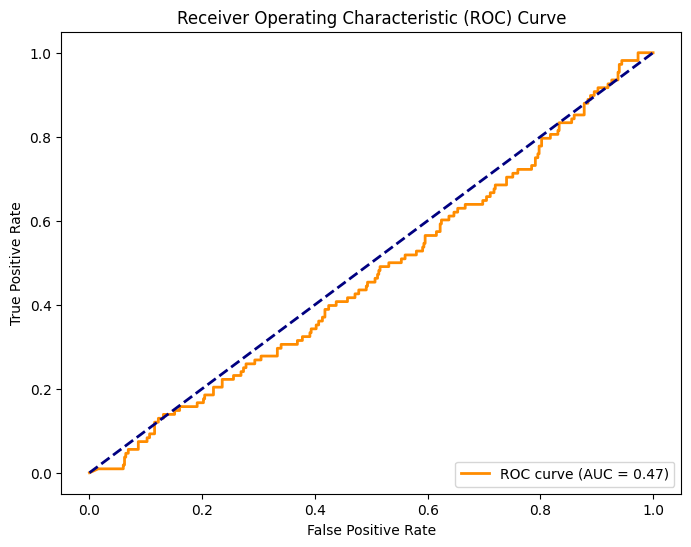

Confusion Matrix
[[422  28]
 [105   3]]


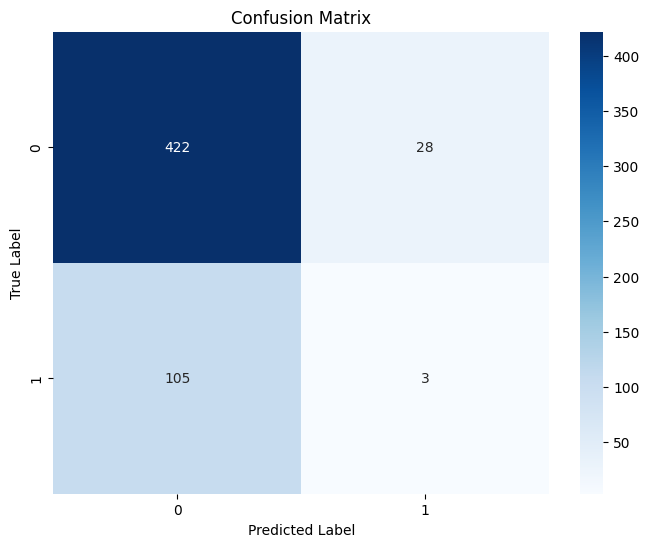

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.80      0.94      0.86       450
     Class 1       0.10      0.03      0.04       108

    accuracy                           0.76       558
   macro avg       0.45      0.48      0.45       558
weighted avg       0.66      0.76      0.71       558



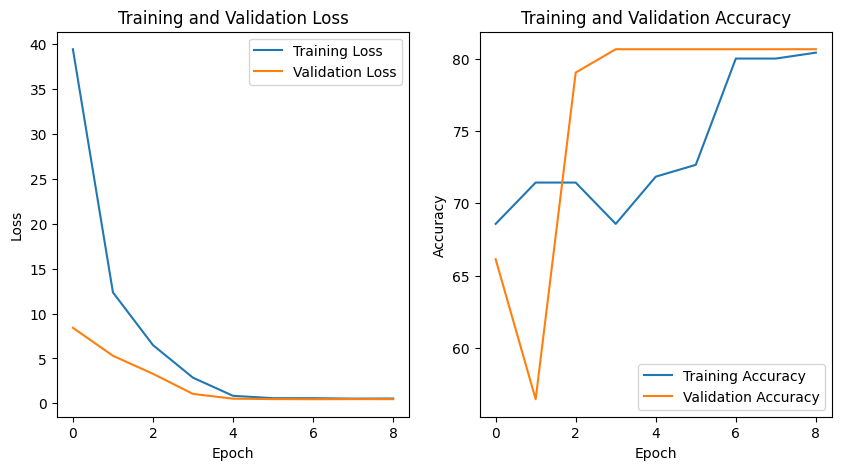

In [ ]:
import torch.optim as optim
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store metrics for plotting
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
all_labels_roc = []
all_probs_roc = []
all_preds = []

# Number of training epochs
num_epochs = 10

# Variables for early stopping
early_stopping_counter = 0
early_stopping_threshold = 5  # Adjust this threshold as needed
best_train_accuracy = 0.0
best_valid_accuracy = 0.0

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels, _, posframe in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        # Move inputs, labels, and posframe to the device
        inputs, labels, posframe = inputs.to(device), labels.to(device), posframe.to(device)

        optimizer.zero_grad()

        # Assuming your model returns a tuple and you want to use the first element
        outputs = model(inputs)[0]

        # Convert labels to the correct data type (torch.long)
        labels = labels.type(torch.long)

        # Use posframe for something during training if needed

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)

    accuracy_train = 100 * correct_train / total_train
    train_accuracies.append(accuracy_train)

    print(f'Training Loss (Epoch {epoch + 1}/{num_epochs}): {average_loss:.4f}')
    print(f'Training Accuracy (Epoch {epoch + 1}/{num_epochs}): {accuracy_train:.2f}%')

    # Validation
    model.eval()
    total_valid_loss = 0.0
    correct_valid = 0
    total_valid = 0

    # Inside the validation loop
    with torch.no_grad():
        for inputs, labels, _, _ in tqdm(valid_loader, desc=f'Validation (Epoch {epoch + 1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)

            # Convert labels to the correct data type (torch.long)
            labels = labels.type(torch.long)

            outputs = model(inputs)[0]
            valid_loss = criterion(outputs, labels)
            total_valid_loss += valid_loss.item()

            _, predicted = outputs.max(1)
            total_valid += labels.size(0)
            correct_valid += predicted.eq(labels).sum().item()

            # Append labels, predicted probabilities, and predictions for ROC curve and confusion matrix
            all_labels_roc.extend(labels.cpu().numpy())
            all_probs_roc.extend(torch.nn.functional.softmax(outputs, dim=1)[:, 1].cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    average_valid_loss = total_valid_loss / len(valid_loader)
    valid_losses.append(average_valid_loss)

    accuracy_valid = 100 * correct_valid / total_valid
    valid_accuracies.append(accuracy_valid)

    print(f'Validation Loss (Epoch {epoch + 1}/{num_epochs}): {average_valid_loss:.4f}')
    print(f'Validation Accuracy (Epoch {epoch + 1}/{num_epochs}): {accuracy_valid:.2f}%')

    # Early stopping check
    if accuracy_train > best_train_accuracy:
        best_train_accuracy = accuracy_train

    if accuracy_valid > best_valid_accuracy:
        best_valid_accuracy = accuracy_valid
        early_stopping_counter = 0
        best_epoch = epoch + 1
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= early_stopping_threshold:
        print(f'Early stopping triggered at epoch {epoch + 1}. Best validation accuracy: {best_valid_accuracy:.2f}% at epoch {best_epoch}')
        break

# Print the best training and validation accuracy
print(f'Best Training Accuracy: {best_train_accuracy:.2f}%')
print(f'Best Validation Accuracy: {best_valid_accuracy:.2f}%')


# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(all_labels_roc, all_probs_roc)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix (at the end)
cm = confusion_matrix(all_labels_roc, all_preds)
print('Confusion Matrix')
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_labels_roc), yticklabels=np.unique(all_preds))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Classification Report (at the end)
report = classification_report(all_labels_roc, all_preds, target_names=['Class 0', 'Class 1'], zero_division=1)
print('Classification Report:\n', report)

# Plotting
plt.figure(figsize=(10, 5))

# Plotting Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
